# ExoJulia
## Andrew Lincowski & Spencer Wallace
## Homework 2a: Exoplanet Transits

In [43]:
# Required packages
#using LsqFit
using PyPlot

In [75]:
# Functions

# 1. Compute overlap of two circles as function of their center-center separation (use law of cosines!)



# 2. Compute transit/secondary eclipse of body (no limb darkening)


function pi_crust(delta::Float64,r::Float64)
    # Calculates overlaps of two circles (the sums of their respective pie crusts)
    #r = sqrt(a*a+b*b): separation of circles center-to-center
    #delta = (Rpl/R*)^2
    # r >= 0
    
    #ingress/egress
    
    if(r >= (1 + sqrt(delta)))
        # outside of transit
        return 0.0
    elseif(r <= (1 - sqrt(delta)))
        # Fully in transit
        return 1.0
    else
        # ingress / egress
        th_st = 2*acos((1+ r*r - delta)/(2*r))
        th_pl = 2*acos((r*r+delta-1)/(2*r*sqrt(delta)))
        alpha = (0.5*th_st - 0.5*sin(th_st) + 0.5*th_pl*delta - 0.5*delta*sin(th_pl))/(pi*delta)
        return alpha
    end
end


# 3. Fit model to mystery_planet2.txt.
#    Calculate planet period P, transit depth K, impact parameter b, and duration of transit T
#    Calculate density of star

function light_curve()
    #uses transit() at array of times to produce light curve 
    
end


function transit(delta::Float64,b::Float64,t::Float64,t0::Float64,v::Float64)
    # delta = (Rpl/R*)^2
    # b = impact parameter
    # t = time
    # t0 = time of contact I
    # v = velocity
    
    #fit: t0, v, b, delta
    
    a = v*(t-t0)
    r = sqrt(a*a+b*b)
    retval = 1 - pi_crust(delta,r)*delta
    return retval
end


# 4. EXTRA: layer cake modelth

# Random functions
function fastsortrows(B::AbstractMatrix,cols::Array; kws...)
  """
  Solution by: abhishekmalali (gihub)
  See: https://github.com/JuliaLang/julia/issues/9832
  """
       for i = 1:length(cols)
        if i == 1
            p =sortperm(B[:,cols[i]]; kws...);
            B = B[p,:];
        else
            i0_old = 0;
            i1_old = 0;
            i0_new = 0;
            i1_new = 0;
            for j = 1:size(B,1)-1
                if B[j,cols[1:i-1]] == B[j+1,cols[1:i-1]] && i0_old == i0_new
                    i0_new = j;
                elseif B[j,cols[1:i-1]] != B[j+1,cols[1:i-1]] && i0_old != i0_new && i1_new == i1_old
                    i1_new = j;
                elseif i0_old != i0_new && j == size(B,1)-1
                    i1_new = j+1;
                end
                if i0_new != i0_old && i1_new != i1_old
                    p = sortperm(B[i0_new:i1_new,cols[i]]; kws...);
                    B[i0_new:i1_new,:] = B[i0_new:i1_new,:][p,:];
                    i0_old = i0_new;
                    i1_old = i1_new;
                end
            end
            end
    end
    return B
end


fastsortrows (generic function with 1 method)

In [76]:
# Data import
pldata = readdlm("mystery_planet2.txt")
time_data = pldata[:,1]
flux_data = pldata[:,2]
err_data = pldata[:,3]

10000-element Array{Float64,1}:
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
  ⋮    
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467

In [72]:
delta = 0.1
Rst = 1.0
Rpl = 0.1
r = linspace(-10,1,1000000)
alpha = Array(Float64,length(r))
for i in 1:(length(r))
    alpha[i]=pi_crust(delta,abs(r[i]))
end
alpha

1000000-element Array{Float64,1}:
 0.0     
 0.0     
 0.0     
 0.0     
 0.0     
 0.0     
 0.0     
 0.0     
 0.0     
 0.0     
 0.0     
 0.0     
 0.0     
 ⋮       
 0.466603
 0.466581
 0.466559
 0.466538
 0.466516
 0.466494
 0.466472
 0.46645 
 0.466428
 0.466406
 0.466384
 0.466363

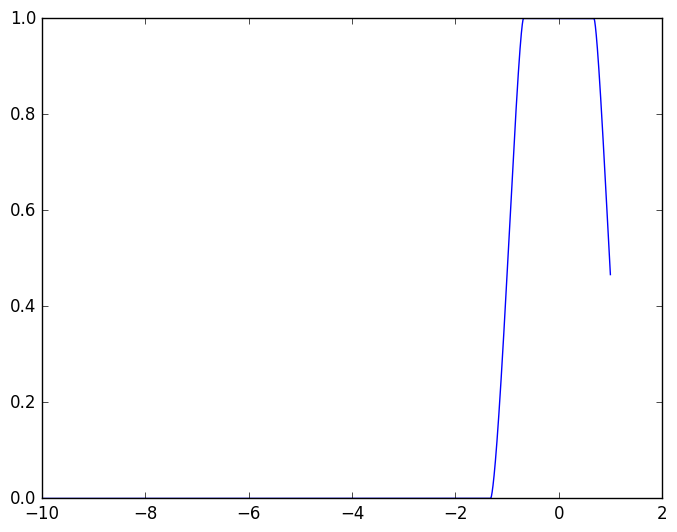

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f042a8df950>

In [73]:
plot(r,alpha)

In [ ]:
#Sort by phase given period
phase = Array(Float64,length(time_data))
phase = mod(time_data,P)
phase_data_arr = [phase RV_data] #combine arrays
phase_sorted = fastsortrows(phase_data_arr, [1]) #sort by phase
